Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts
License(s): DbCL-1.0
 81% 88.0M/109M [00:01<00:00, 98.6MB/s]
100% 109M/109M [00:01<00:00, 99.1MB/s] 
Dataset URL: https://www.kaggle.com/datasets/boltcutters/food-allergens-and-allergies
License(s): copyright-authors
  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 6.67MB/s]
Files in /content/data: ['en.openfoodfacts.org.products.tsv']
Files in /content/data2: ['FoodData.csv']
Error loading food allergen dataset: [Errno 2] No such file or directory: '/content/data2/food_allergens.csv'
Using sample simulated food allergen data.
      Food                Allergy
0   almond            Nut Allergy
1    apple  Oral Allergy Syndrome
2  apricot    Stone Fruit Allergy
3   walnut            Nut Allergy
4    honey          Honey

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0



Initialized NER pipeline with model 'sgarbi/bert-fda-nutrition-ner'.

=== Recipe Analysis and Recommendations ===

Recipe: Recipe 1
Ingredients: Dried apricots, walnuts, honey, lemon juice
Detected Allergies: ['Citrus Allergy', 'Nut Allergy', 'Honey Allergy']
Allergic Ingredient Percentages: {'Honey Allergy': 25.0}
For Citrus Allergy, consider alternatives: Apple, Pear, Berry juice
For Nut Allergy, consider alternatives: Sunflower seeds, Pumpkin seeds, Pea protein
For Honey Allergy, consider alternatives: Maple syrup, Agave syrup


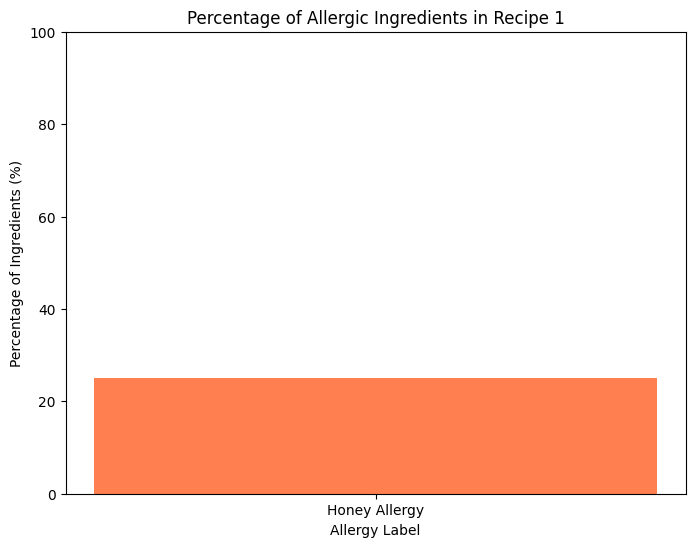


Recipe: Recipe 2
Ingredients: Apples, almond butter, wheat flour
Detected Allergies: ['Dairy Allergy', 'Nut Allergy']
Allergic Ingredient Percentages: {}
For Dairy Allergy, consider alternatives: Soy milk, Almond milk
For Nut Allergy, consider alternatives: Sunflower seeds, Pumpkin seeds, Pea protein

Saving the model and tokenizer locally for future use...


Some weights of BertModel were not initialized from the model checkpoint at sgarbi/bert-fda-nutrition-ner and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved successfully!


In [1]:
# ===============================
# STEP 0: Setup Kaggle in Colab
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# Set up Kaggle API (ensure your kaggle.json is in your Google Drive)
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # Adjust the path if necessary
!chmod 600 ~/.kaggle/kaggle.json

# ===============================
# STEP 1: Download Datasets from Kaggle
# ===============================
!mkdir -p /content/data
!kaggle datasets download -d openfoodfacts/world-food-facts -p /content/data --unzip

!mkdir -p /content/data2
!kaggle datasets download boltcutters/food-allergens-and-allergies -p /content/data2 --unzip

import os
print("Files in /content/data:", os.listdir('/content/data'))
print("Files in /content/data2:", os.listdir('/content/data2'))

# ===============================
# STEP 2: Load and Prepare Datasets
# ===============================
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt

# 2.1 Food Allergen Data
# Adjust the filename/column names based on the dataset structure.
allergen_file = '/content/data2/food_allergens.csv'  # Change as needed
try:
    food_allergen_df = pd.read_csv(allergen_file)
    print("Loaded food allergen dataset from:", allergen_file)
except Exception as e:
    print("Error loading food allergen dataset:", e)
    # Fallback: use simulated data
    data = {
        "Food": ["almond", "apple", "apricot", "walnut", "honey", "lemon", "butter"],
        "Allergy": ["Nut Allergy", "Oral Allergy Syndrome", "Stone Fruit Allergy", "Nut Allergy", "Honey Allergy", "Citrus Allergy", "Dairy Allergy"]
    }
    food_allergen_df = pd.DataFrame(data)
    print("Using sample simulated food allergen data.")
print(food_allergen_df.head())

# Build the food-allergy dictionary.
food_allergy_dict = {}
for idx, row in food_allergen_df.iterrows():
    food_key = str(row["Food"]).lower().strip()
    allergy_label = row["Allergy"]
    if food_key not in food_allergy_dict:
        food_allergy_dict[food_key] = set()
    food_allergy_dict[food_key].add(allergy_label)

print("\nSample Food-Allergy Mapping:")
for food, allergies in list(food_allergy_dict.items())[:5]:
    print(f"  {food}: {allergies}")

# 2.2 Alternative Foods Data
# Try to load an alternative foods CSV; if not, use a sample mapping.
alt_file = '/content/data2/alternative_foods.csv'  # Adjust filename if available
try:
    alt_df = pd.read_csv(alt_file)
    alternative_foods = {}
    for idx, row in alt_df.iterrows():
        alternatives = [alt.strip() for alt in str(row["Alternatives"]).split(',')]
        alternative_foods[row["Allergy"]] = alternatives
    print("\nLoaded alternative foods dataset from:", alt_file)
except Exception as e:
    print("\nAlternative foods CSV not found or error loading it. Using sample alternative foods data.")
    alternative_foods = {
        "Nut Allergy": ["Sunflower seeds", "Pumpkin seeds", "Pea protein"],
        "Citrus Allergy": ["Apple", "Pear", "Berry juice"],
        "Honey Allergy": ["Maple syrup", "Agave syrup"],
        "Oral Allergy Syndrome": ["Cooked apples", "Steamed carrots"],
        "Stone Fruit Allergy": ["Banana", "Kiwi"],
        "Dairy Allergy": ["Soy milk", "Almond milk"]
    }
print("\nAlternative Food Recommendations Mapping:")
for allergy, alts in alternative_foods.items():
    print(f"  {allergy}: {alts}")

# 2.3 Recipe Data
# Load a recipe CSV if available; otherwise, use simulated sample data.
recipe_file = '/content/data/recipe_data.csv'  # Adjust path/filename if available
try:
    recipes_df = pd.read_csv(recipe_file)
    print("\nLoaded recipe dataset from:", recipe_file)
except Exception as e:
    print("\nRecipe dataset not found. Using sample simulated recipe data.")
    recipes_data = {
        "Recipe": ["Recipe 1", "Recipe 2"],
        "Ingredients": [
            "Dried apricots, walnuts, honey, lemon juice",
            "Apples, almond butter, wheat flour"
        ]
    }
    recipes_df = pd.DataFrame(recipes_data)
print(recipes_df.head())

# ===============================
# STEP 3: Initialize the NER Pipeline
# ===============================
from transformers import pipeline, AutoModel, AutoTokenizer
model_name = "sgarbi/bert-fda-nutrition-ner"
ner_pipe = pipeline("token-classification", model=model_name)
print(f"\nInitialized NER pipeline with model '{model_name}'.")

# ===============================
# STEP 4: Define Core Functions
# ===============================
def get_allergies_from_ingredients(ingredients_text: str):
    """
    Detect food items using the NER pipeline, then cross-check with food_allergy_dict to determine allergy labels.
    """
    ner_results = ner_pipe(ingredients_text)
    detected_allergies = set()
    for token_info in ner_results:
        token = token_info["word"]
        token_clean = re.sub(r'\W+', '', token.lower().strip())
        if token_clean in food_allergy_dict:
            detected_allergies.update(food_allergy_dict[token_clean])
    return list(detected_allergies)

def calculate_allergic_percentages(ingredients_text: str):
    """
    Split ingredients (comma-separated) and calculate the percentage of ingredients triggering each allergy.
    """
    ingredients = [ing.strip().lower() for ing in ingredients_text.split(',')]
    total = len(ingredients)
    allergy_counts = {}
    for ingredient in ingredients:
        cleaned = re.sub(r'\W+', '', ingredient)
        if cleaned in food_allergy_dict:
            for allergy in food_allergy_dict[cleaned]:
                allergy_counts[allergy] = allergy_counts.get(allergy, 0) + 1
    percentages = {allergy: (count / total) * 100 for allergy, count in allergy_counts.items()}
    return percentages

def get_alternative_recommendations(detected_allergies):
    """
    For each detected allergy, return alternative ingredient recommendations using the alternative_foods mapping.
    """
    recommendations = {}
    for allergy in detected_allergies:
        recommendations[allergy] = alternative_foods.get(allergy, ["No alternative recommendation available"])
    return recommendations

# ===============================
# STEP 5: Process Recipes, Visualize, and Recommend Alternatives
# ===============================
print("\n=== Recipe Analysis and Recommendations ===")
for idx, row in recipes_df.iterrows():
    recipe_name = row["Recipe"]
    ingredients_text = row["Ingredients"]
    print(f"\nRecipe: {recipe_name}")
    print(f"Ingredients: {ingredients_text}")

    # Detect allergens
    detected_allergies = get_allergies_from_ingredients(ingredients_text)
    print("Detected Allergies:", detected_allergies)

    # Calculate allergic ingredient percentages
    allergy_percentages = calculate_allergic_percentages(ingredients_text)
    print("Allergic Ingredient Percentages:", allergy_percentages)

    # Get alternative recommendations
    alternatives = get_alternative_recommendations(detected_allergies)
    for allergy, alts in alternatives.items():
        print(f"For {allergy}, consider alternatives: {', '.join(alts)}")

    # Visualization: Bar chart for allergenic ingredient percentages
    if allergy_percentages:
        plt.figure(figsize=(8,6))
        labels = list(allergy_percentages.keys())
        percents = list(allergy_percentages.values())
        plt.bar(labels, percents, color='coral')
        plt.xlabel("Allergy Label")
        plt.ylabel("Percentage of Ingredients (%)")
        plt.title(f"Percentage of Allergic Ingredients in {recipe_name}")
        plt.ylim(0, 100)
        plt.show()

# ===============================
# STEP 6: (Optional) Save the Model and Tokenizer Locally
# ===============================
print("\nSaving the model and tokenizer locally for future use...")
model = AutoModel.from_pretrained(model_name)
model.save_pretrained("./downloaded_model")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained("./downloaded_model")
print("Model and tokenizer saved successfully!")


Allergic Ingredient Percentages: {'Oral Allergy Syndrome': 33.33333333333333, 'Nut Allergy': 33.33333333333333, 'Dairy Allergy': 33.33333333333333}


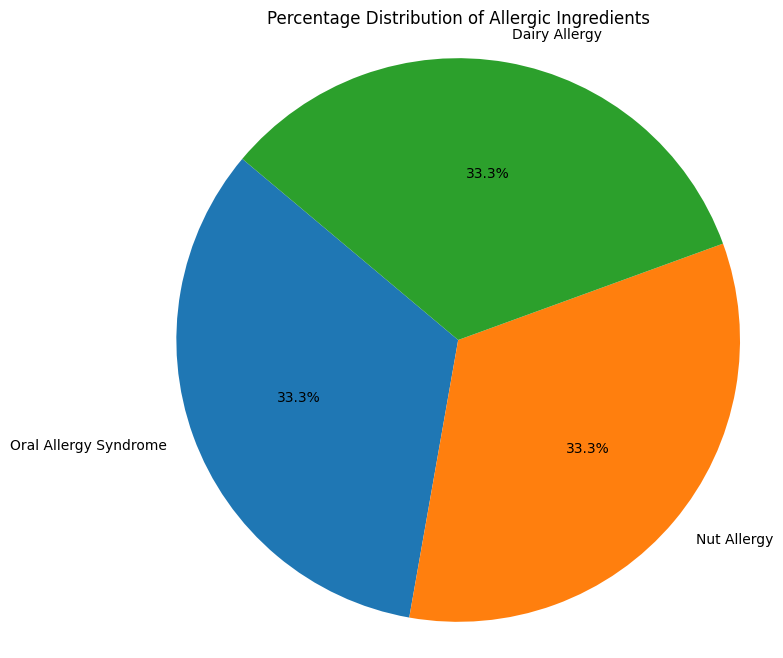

In [4]:
# Calculate the allergic ingredient percentages for a given recipe
ingredients_text = "Apples, almond butter, wheat flour"
allergy_percentages = calculate_allergic_percentages(ingredients_text)
print("Allergic Ingredient Percentages:", allergy_percentages)

# Draw a pie chart if there are any allergic percentages
if allergy_percentages:
    labels = list(allergy_percentages.keys())
    sizes = list(allergy_percentages.values())

    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Percentage Distribution of Allergic Ingredients")
    plt.axis('equal')  # Ensures the pie chart is a circle.
    plt.show()
else:
    print("No allergic ingredients detected.")
